A notebook for trying and working on the libraries to be used

Using Jaxns jones example to test out stuff

In [1]:
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import numpy as jnp
from jax import random

from jaxns import ExactNestedSampler
from jaxns import TerminationCondition
from jaxns import analytic_log_evidence

tfpd = tfp.distributions

INFO[2023-06-18 21:40:49,006]: Remote TPU is not linked into jax; skipping remote TPU.
INFO[2023-06-18 21:40:49,006]: Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO[2023-06-18 21:40:49,006]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-18 21:40:49,006]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-18 21:40:49,007]: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO[2023-06-18 21:40:49,007]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


In [2]:
a = jnp.array([1., 2., 3., 4, 5, 6, 7, 8, 9, 10])
print(a.shape)
b = jnp.array([1., 2.])
print(b.shape)
c = b[:,jnp.newaxis]
d = jnp.array([2.0, 3.0])[:,jnp.newaxis]
print(c.shape)
print(((a-c)[..., None]).shape )
print((a-c).shape)
print((a-c)*d)

print(jnp.sum((a-c)*d, axis=0))
print(jnp.sum((a-c)*d, axis=0).shape)

(10,)
(2,)
(2, 1)
(2, 10, 1)
(2, 10)
[[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
 [-3.  0.  3.  6.  9. 12. 15. 18. 21. 24.]]
[-3.  2.  7. 12. 17. 22. 27. 32. 37. 42.]
(10,)


In [3]:
TEC_CONV = -8.4479745  #rad*MHz/mTECU
CLOCK_CONV = (2e-3 * jnp.pi)  #rad/MHz/ns


def wrap(phi):
    return (phi + jnp.pi) % (2 * jnp.pi) - jnp.pi


def generate_data(key, uncert):
    """
    Generate gain data where the phase have a clock const and tec component. This is a model of the impact of the ionosphere on the propagation of radio waves, part of radio interferometry:

    phase[:] = tec * (tec_conv / freqs[:]) + clock * (clock_conv * freqs[:]) + const

    then the gains are:

        gains[:] ~ Normal[{cos(phase[:]), sin(phase[:])}, uncert^2 * I]

    phase_obs[:] = ArcTan[gains.imag, gains.real]

    Args:
        key:
        uncert: uncertainty of the gains

    Returns:
        phase_obs, freqs
    """
    freqs = jnp.linspace(121, 166, 24)  #MHz
    tec = 90.  #mTECU
    const = 2.  #rad
    clock = 0.5  #ns
    phase = wrap(tec * (TEC_CONV / freqs) + clock * (CLOCK_CONV * freqs) + const)
    Y = jnp.concatenate([jnp.cos(phase), jnp.sin(phase)], axis=-1)
    Y_obs = Y + uncert * random.normal(key, shape=Y.shape)
    phase_obs = jnp.arctan2(Y_obs[..., freqs.size:], Y_obs[..., :freqs.size])
    return phase, phase_obs, freqs

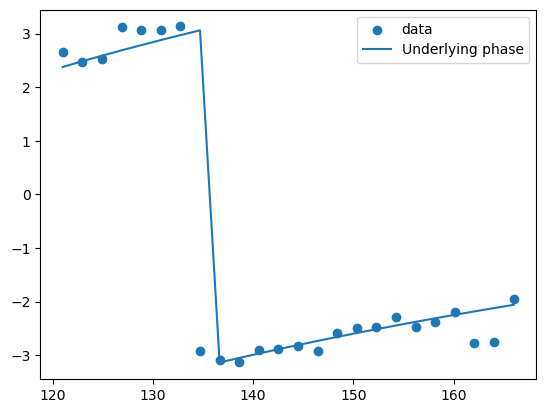

In [4]:
# Generate data
key = random.PRNGKey(43)
key, data_key = random.split(key)
phase_underlying, phase_obs, freqs = generate_data(data_key, 0.25)
plt.scatter(freqs, phase_obs, label='data')
plt.plot(freqs, phase_underlying, label='Underlying phase')
plt.legend()
plt.show()
# Note: the phase wrapping makes this a difficult problem to solve. As we'll see, the posterior is rather complicated.

In [5]:
from jaxns import Prior, Model
from jax import numpy as jnp
from jax import random

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels


def log_normal(x, mean, scale):
    dx = (x - mean) / scale
    return -0.5 * jnp.log(2. * jnp.pi) - jnp.log(scale) - 0.5 * dx * dx

# def prior_model():
#     tec = yield Prior(tfpd.Cauchy(0., 100.), name='tec')
#     const = yield Prior(tfpd.Uniform(-jnp.pi, jnp.pi), name='const')
#     clock = yield Prior(tfpd.Uniform(-2., 2.), name='clock')
#     uncert = yield Prior(tfpd.HalfNormal(0.5), name='uncert')
#     # This biject works although should use transformed distribution
#     biject = yield Prior( tfb.Shift(0.0)( tfb.Scale(20.0) (tfd.Beta(1,3)) ),name = 'biject' )
#     jointds = yield Prior(tfd.JointDistributionSequential([
#             tfb.Shift(0.0)( tfb.Scale(20.0) (tfd.Beta(1,3)) ),                       # t_0
#             lambda t_0: tfb.Shift(t_0)( tfb.Scale(20-t_0) (tfd.Beta(1,2)) ),         # t_1 
#             lambda t_1: tfb.Shift(t_1)( tfb.Scale(20-t_1) (tfd.Beta(1,1)) ),         # t_2 
#         ]) )



# We cannot use key word arguments in the log_likelihood function in jaxns
# We will have to give exact parameters to the function in any case

# def log_likelihood(**kwargs):
#     phase = kwargs["tec"] * (TEC_CONV / freqs) + kwargs["const"] + kwargs["clock"] * (CLOCK_CONV * freqs)
#     logL = log_normal(wrap(wrap(phase) - wrap(phase_obs)), 0., kwargs["uncert"])
#     return jnp.sum(logL)

def log_likelihood(tec, const, clock, uncert):
# def log_likelihood(*args):
    phase = tec * (TEC_CONV / freqs) + const + clock * (CLOCK_CONV * freqs)
    logL = log_normal(wrap(wrap(phase) - wrap(phase_obs)), 0., uncert)
    return jnp.sum(logL)
    # phase = args[0] * (TEC_CONV / freqs) + args[1] + args[2] * (CLOCK_CONV * freqs)
    # logL = log_normal(wrap(wrap(phase) - wrap(phase_obs)), 0., args[3])
    # return jnp.sum(logL)

def prior1():
    tec = yield Prior(tfpd.Cauchy(0., 100.), name='tec')
    const = yield Prior(tfpd.Uniform(-jnp.pi, jnp.pi), name='const')

    return tec, const

def prior2():
    clock = yield Prior(tfpd.Uniform(-2., 2.), name='clock')
    uncert = yield Prior(tfpd.HalfNormal(0.5), name='uncert')

    return clock, uncert


def prior_model():
    tec = yield Prior(tfpd.Cauchy(0., 100.), name='tec')
    const = yield Prior(tfpd.Uniform(-jnp.pi, jnp.pi), name='const')
    clock = yield Prior(tfpd.Uniform(-2., 2.), name='clock')
    uncert = yield Prior(tfpd.HalfNormal(0.5), name='uncert')
    
    # priorno1 = prior1()
    # priorno2 = prior2()
    # return prior1(), prior2()
    return *prior1(), *prior2()
    # return tec, const, clock, uncert
    # return dict(tec=tec, const=const, clock=clock, uncert=uncert)

model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)

# log_Z_true = analytic_log_evidence(model=model, S=80)
# print(f"True log(Z)={log_Z_true}")

TypeError: unsupported operand type(s) for *: 'Prior' and 'DynamicJaxprTracer'

In [6]:
def prior_model():
    tec = yield Prior(tfpd.Cauchy(0., 100.), name='tec')
    const = yield Prior(tfpd.Uniform(-jnp.pi, jnp.pi), name='const')
    clock = yield Prior(tfpd.Uniform(-2., 2.), name='clock')
    uncert = yield Prior(tfpd.HalfNormal(0.5), name='uncert')
    
    # return prior1(), prior2()
    return *prior1(), *prior2()
    # return tec, const, clock, uncert
    # return dict(tec=tec, const=const, clock=clock, uncert=uncert)

prior_objects = prior_model()

print(prior_objects)

# print(*prior_objects)

for prior_obj in prior_objects:
    print(prior_obj)

# for prior_obj in prior_objects:
#     print(prior_obj)
#     for obj in prior_obj:
#         print(obj)

<generator object prior_model at 0x1788acac0>
tec	() -> () float32
const	() -> () <class 'numpy.float32'>
clock	() -> () <class 'numpy.float32'>
uncert	() -> () <class 'numpy.float32'>


In [7]:
# Create the nested sampler class. In this case without any tuning.
ns = exact_ns = ExactNestedSampler(model=model, num_live_points=500, max_samples=1e4, uncert_improvement_patience=2)

termination_reason, state = exact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = exact_ns.to_results(state, termination_reason)

TypeError: unsupported operand type(s) for *: 'Prior' and 'DynamicJaxprTracer'

In [8]:
# We can use the summary utility to display results
exact_ns.summary(results)

NameError: name 'results' is not defined

Gives the summary for the 4 parameters (tec, const, clock, uncert)

In [15]:
def fun1(**kwargs):
    print(kwargs["word"])
    print(kwargs["word2"])

diction = {"word": "hello", "word2": "world"}
fun1(**diction)

hello
world


Using and understanding tensorflow_probability.substrates.jax.distributions

In [9]:
from jax import numpy as jnp
from jax import random

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels
X = jnp.arange(7)

jds = tfd.JointDistributionSequential([
    tfd.Normal(loc=0., scale=1.),   # m
    tfd.Normal(loc=0., scale=1.),   # b
    lambda b, m: tfd.Normal(loc=m*X + b, scale=1.) # Y
])

dists, sample = jds.sample_distributions(seed = random.PRNGKey(0))
sample

[Array(-1.3508357, dtype=float32),
 Array(0.65438056, dtype=float32),
 Array([ 2.150156 , -1.1394691, -2.93377  , -5.992399 , -5.2456484,
        -5.8377233, -6.5910163], dtype=float32)]

In [10]:
dists

[<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>,
 <tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>,
 <tfp.distributions.Normal 'Normal' batch_shape=[7] event_shape=[] dtype=float32>]

In [11]:
sh = tfb.Shift(10.0)
sc = tfb.Scale(5.0)
scaled_shifted = sh(sc(tfd.Normal(loc=0., scale=1.)))
scaled_shifted.sample(seed = random.PRNGKey(4))

Array(5.0717063, dtype=float32)

In [12]:
# Code for joint beta distribution
# Pretty good
jointds = tfd.JointDistributionSequential([
    tfb.Shift(0.0)( tfb.Scale(20.0) (tfd.Beta(1,3)) ),                       # t_0
    lambda t_0: tfb.Shift(t_0)( tfb.Scale(20-t_0) (tfd.Beta(1,2)) ),         # t_1 
    lambda t_1: tfb.Shift(t_1)( tfb.Scale(20-t_1) (tfd.Beta(1,1)) ),         # t_2 
])
jointds.sample(seed = random.PRNGKey(9))

[Array(8.805645, dtype=float32),
 Array(13.365799, dtype=float32),
 Array(16.5056, dtype=float32)]

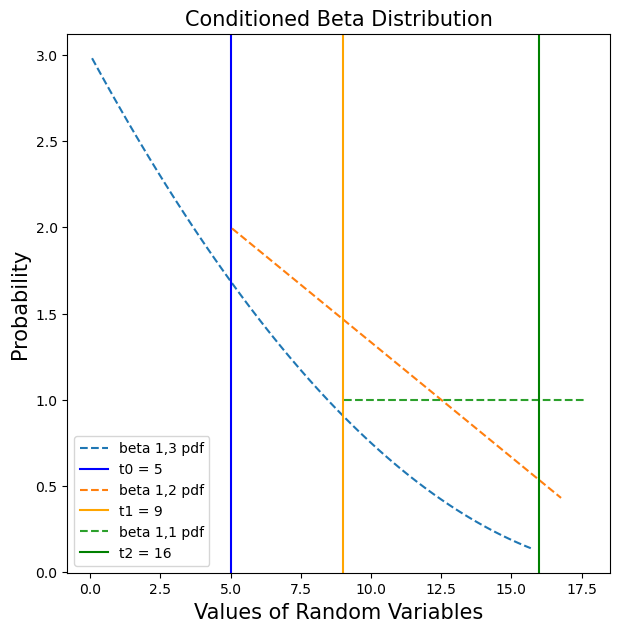

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

a, b = 1, 3

plt.figure(figsize=(7,7))
x = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)
y = beta.pdf(x, a, b)
plt.plot(20*x, beta.pdf(x, a, b), '--', label='beta 1,3 pdf')
plt.axvline(x = 5, color = 'b', label = 't0 = 5')

a,b = 1,2
x1 = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)
y1 = beta.pdf(x1, a, b)
plt.plot((20-5)*x+5, beta.pdf(x, a, b), '--', label='beta 1,2 pdf')
plt.axvline(x = 9, color = 'orange', label = 't1 = 9')

a,b = 1,1
x1 = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)
y1 = beta.pdf(x1, a, b)
plt.plot((20-9)*x+9, beta.pdf(x, a, b), '--', label='beta 1,1 pdf')
plt.axvline(x = 16, color = 'green', label = 't2 = 16')

plt.plot()
plt.title('Conditioned Beta Distribution', fontsize='15')
plt.xlabel('Values of Random Variables', fontsize='15')
plt.ylabel('Probability', fontsize='15')
plt.legend()
# plt.label()
plt.show()

In [36]:
dist2 = tfd.Cauchy(0., 100.)
dist2

dist3 = tfd.Beta(1,2)
dist3

# Cannot be done * or +
# y = 3 + (10-2)*tfd.Beta(1,2)

exp_bijector = tfp.bijectors.Exp()
log_normal = exp_bijector(tfd.Normal(5, .5))
log_normal  # It is showing a transformed distribution

u1 = tfd.Uniform(low=3.0, high=4.0)
u1.sample(seed = random.PRNGKey(0))
#log_normal.sample(seed = random.PRNGKey(0))

Array(3.418457, dtype=float32)

In [22]:
jds = tfd.JointDistributionSequential([
    tfd.Beta(1,2),   # m
    lambda m: tfd.Normal(loc=m*X, scale=1.) # Y
])

dists, sample = jds.sample_distributions(seed = random.PRNGKey(0))
dists

[<tfp.distributions.Beta 'Beta' batch_shape=[] event_shape=[] dtype=float32>,
 <tfp.distributions.Normal 'Normal' batch_shape=[7] event_shape=[] dtype=float32>]

In [50]:
jds = tfd.JointDistributionSequential([
    tfd.Uniform(low=0.0, high=4.0),                # t_0
    lambda t_0 : tfd.Uniform(low=t_0, high=4.0),   # t_1
    lambda t_1: tfd.Uniform(low=t_1, high=4.0)     # t_2
])

dists, sample = jds.sample_distributions(seed = random.PRNGKey(9))
# dists


# we want the dists separately

<tfp.distributions.JointDistributionSequential 'JointDistributionSequential' batch_shape=[[], [], []] event_shape=[[], [], []] dtype=[float32, float32, float32]>

In [53]:
def log_normal(x, mean, scale):
    dx = (x - mean) / scale
    return -0.5 * jnp.log(2. * jnp.pi) - jnp.log(scale) - 0.5 * dx * dx


def log_likelihood(joint_d):
    # logL = log_normal(joint_d[0], 0., 1.) + log_normal(joint_d[1], joint_d[0], 1.) + log_normal(joint_d[2], joint_d[1], 1.)
    return -13

def prior_model():
    jds = tfd.JointDistributionSequential([
        tfd.Uniform(low=0.0, high=4.0),                # t_0
        lambda t_0 : tfd.Uniform(low=t_0, high=4.0),   # t_1
        lambda t_1: tfd.Uniform(low=t_1, high=4.0)     # t_2
        ])
    
    joint_d = yield Prior(jds, name='joint_d')
    
    return joint_d

model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

# model.sanity_check(random.PRNGKey(0), S=100)

# make the beta prior using joint, transformed, beta, shift, scale
# Check if joint distributions can be used in jaxns
# Look up special priors, think if you can make something like that


InvalidDistribution: Distribution tfp.distributions.JointDistributionSequential("JointDistributionSequential", batch_shape=[[], [], []], event_shape=[[], [], []], dtype=[float32, float32, float32]) is missing a quantile. Try checking if your desired prior exists in `jaxns.special_priors`.

Using Tinygp

In [24]:
from tinygp import kernels, GaussianProcess

import numpy as np
import matplotlib.pyplot as plt


def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")

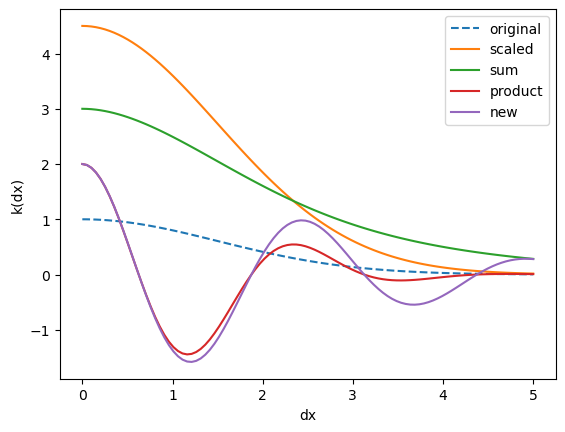

In [39]:
kernel = kernels.ExpSquared(scale=1.5)
plot_kernel(kernel, label="original", ls="dashed")

kernel_scaled = 4.5 * kernels.ExpSquared(scale=1.5)
plot_kernel(kernel_scaled, label="scaled")

kernel_sum = kernels.ExpSquared(scale=1.5) + 2 * kernels.Matern32(scale=2.5)
plot_kernel(kernel_sum, label="sum")

kernel_prod = 2 * kernels.ExpSquared(scale=1.5) * kernels.Cosine(scale=2.5)
plot_kernel(kernel_prod, label="product")

kernel_new =  2 * kernels.Cosine(scale=2.5) * kernels.Matern32(scale=2.5)
plot_kernel(kernel_new, label="new")

_ = plt.legend()

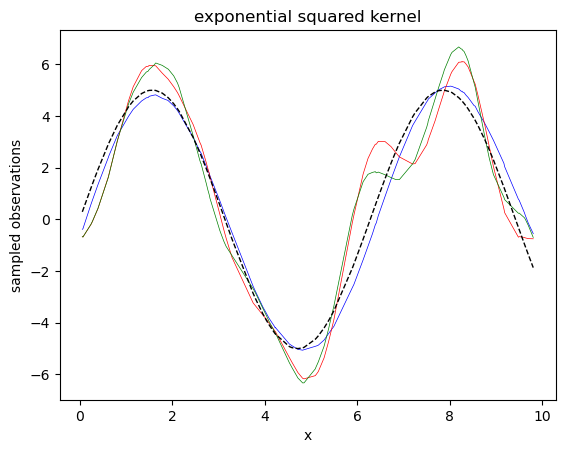

In [43]:
from tinygp import GaussianProcess

def mean_function(x):
    return 5 * jnp.sin(x)

# Let's make up some input coordinates (sorted for plotting purposes)
X = np.sort(np.random.default_rng(1).uniform(0, 10, 100))
gp_exp = GaussianProcess(kernel, X, mean= mean_function)
gp_prod = GaussianProcess(kernel_prod, X, mean= mean_function)
gp_new = GaussianProcess(kernel_new, X, mean= mean_function)

y_exp = gp_exp.sample(random.PRNGKey(6), shape=(1,))
y_prod = gp_prod.sample(random.PRNGKey(6), shape=(1,))
y_new = gp_new.sample(random.PRNGKey(6), shape=(1,))
plt.plot(X, y_exp.T, color = "b", lw=0.5)
plt.plot(X, y_prod.T, color = "r", lw=0.5)
plt.plot(X, y_new.T, color = "g", lw=0.5)
plt.plot(X, mean_function(X), color = "k", lw=1 , ls = "dashed")
plt.xlabel("x")
plt.ylabel("sampled observations")
_ = plt.title("exponential squared kernel")

# Result: The samples are quite different.
# The samples are quite similar if we use a mean function

In [4]:
def myFun(*argv):
    for arg in argv:
        print(arg)
 
 
myFun('Hello', 'Welcome', 'to', 'GeeksforGeeks')

hi
Hello
Welcome
to
GeeksforGeeks


In [10]:
import numpy as np
def funct(n):
    for i in range(n):
        return tuple(np.linspace(0,n,n+1))
    
def myFun2():
    myFun(*funct(5))

myFun2()

hi
0.0
1.0
2.0
3.0
4.0
5.0
